# Batch Segmentation Workflow

This notebook shows an example of how to do batch processing for 3D nuclei image segmentation.

In [1]:
import napari
from napari.utils import nbscreenshot
from skimage.io import imread, imsave
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import pyclesperanto_prototype as cle
import napari_skimage_regionprops as nsr
import napari_process_points_and_surfaces as nppas
from napari_stl_exporter import napari_write_surfaces
from pathlib import Path
import pandas as pd
import watermark

Batch processing becomes easy once you manage to put the individual steps of your workflow into a single python function (or just a few functions).

In this function below, we essentially copied each step of the workflow and pasted them in the right order.

In the very beginning there are a few lines that create an `"outputs"` folder in case it does not exist in the file folder.

In [2]:
def my_workflow(file_path):
    """Apply custom 3D nuclei segmentation and save properties and largest surface

    Parameters
    ----------
    file_path : str
        Path to image file

    Returns
    -------
    image3_el : array
        Segmentation results as a labeled image
    largest_label_to_surface : array
        Largest label turned into surface
    """
    
    file_path = Path(file_path)
    output_path = (file_path.parent / "outputs")
    if output_path.exists() == False:
        output_path.mkdir(parents=True, exist_ok=True)
    file_name = file_path.stem
    
    # Read image
    image0_n = imread(file_path)
    # Apply voronoi otsu labeling from nsbatwm
    image1_V = nsbatwm.voronoi_otsu_labeling(image0_n, 9.0, 2.0)
    # Dilate labels
    image2_dl = cle.dilate_labels(image1_V, None, 3.0)
    # Erode labels
    image3_el = cle.erode_labels(image2_dl, None, 3.0, False)
    # Save image to disk
    imsave(output_path / ('segmentation_results_' + file_name + '.tif'), image3_el)
    # Measure properties
    table = pd.DataFrame(nsr.regionprops_table(image0_n, image3_el, shape = True))
    # Save propeties to disk
    table.to_csv(output_path / ('table_' + file_name + '.csv'))
    # Turn biggest label into surface
    largest_label_to_surface = nppas.largest_label_to_surface(image3_el)
    # Save surface to disk
    output_surface_path_string = str(output_path / ('largest_surface_' + file_name + '.stl'))
    napari_write_surfaces(output_surface_path_string, largest_label_to_surface, None)
    
    return image3_el, largest_label_to_surface

And set the path to the folder containing data.

In [3]:
data_path = "../data"
data_path = Path(data_path)

# Run function on example image 

In [5]:
example_image_path = data_path / 'nuclei3d.tif'
example_image_path

WindowsPath('../data/nuclei3d.tif')

Read example image (just to visualize it in napari).

In [6]:
image0_n = imread(example_image_path)

Apply function to example image and display results in napari.

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_8632\94898688.py:32: UserWarning: C:\Users\mazo260d\Documents\GitHub\napari-introduction-4-Image-Analysis-and-Data-Processing-in-Super-Resolution-Microscopy-2023\data\outputs\segmentation_results_nuclei3d.tif is a low contrast image
  imsave(output_path / ('segmentation_results_' + file_name + '.tif'), image3_el)


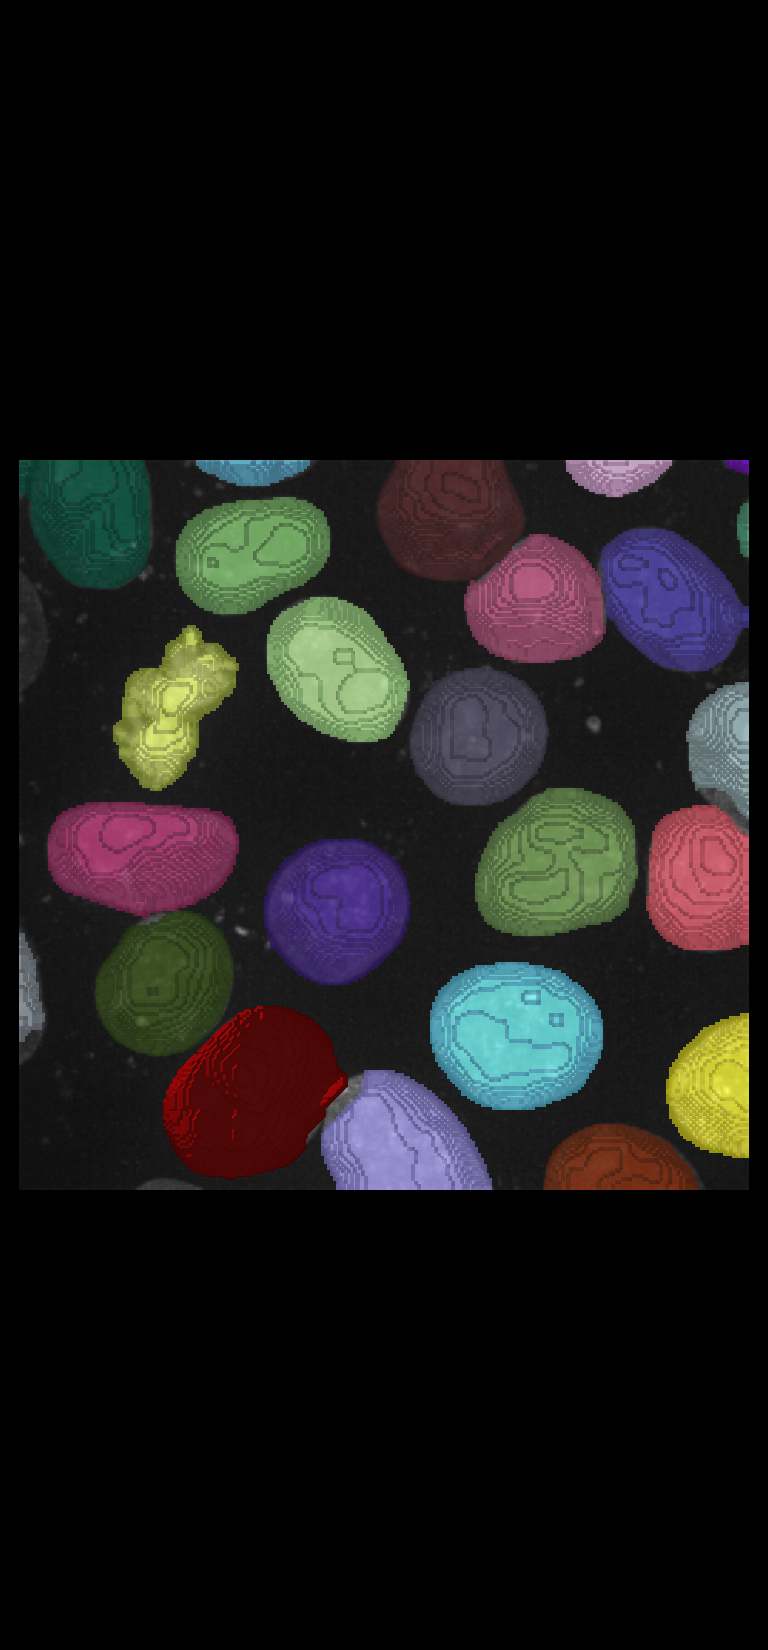

In [7]:
viewer = napari.Viewer()
viewer.add_image(image0_n)

label_image, largest_surface = my_workflow(example_image_path)

viewer.add_labels(label_image)

viewer.add_surface(largest_surface, colormap = 'red', opacity = 0.9)

viewer.dims.ndisplay = 3

nbscreenshot(viewer, canvas_only = True)

# Batch processing

In [8]:
for file_path in data_path.glob('*.tif'):
    label_image, largest_surface = my_workflow(file_path)

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_8632\94898688.py:32: UserWarning: C:\Users\mazo260d\Documents\GitHub\napari-introduction-4-Image-Analysis-and-Data-Processing-in-Super-Resolution-Microscopy-2023\data\outputs\segmentation_results_nuclei3d.tif is a low contrast image
  imsave(output_path / ('segmentation_results_' + file_name + '.tif'), image3_el)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_8632\94898688.py:32: UserWarning: C:\Users\mazo260d\Documents\GitHub\napari-introduction-4-Image-Analysis-and-Data-Processing-in-Super-Resolution-Microscopy-2023\data\outputs\segmentation_results_nuclei3d_cropped.tif is a low contrast image
  imsave(output_path / ('segmentation_results_' + file_name + '.tif'), image3_el)


## Package versions used to run this notebook

In [6]:
%load_ext watermark
%watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-08-03T16:26:07.574388+02:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

watermark                                     : 2.4.3
napari_skimage_regionprops                    : 0.10.1
pandas                                        : 2.0.3
pyclesperanto_prototype                       : 0.24.1
napari                                        : 0.4.18
napari_process_points_and_surfaces            : 0.5.0
napari_segment_blobs_and_things_with_membranes: 0.3.6

